In [1]:
import pyzx as zx
import random
from qiskit import QuantumCircuit
from copy import deepcopy

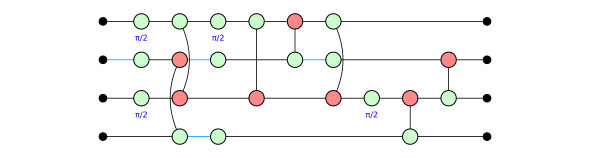

In [3]:
qubit = 4
depth = 15
random.seed(22)
circ = zx.generate.CNOT_HAD_PHASE_circuit(qubit, depth, clifford=True)
zx.draw_matplotlib(circ)

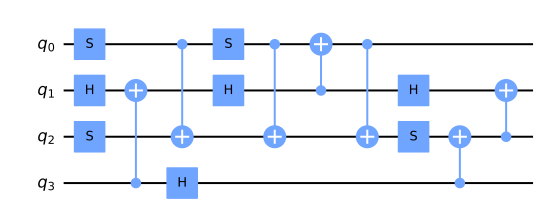

In [4]:
circ_qasm_text = circ.to_qasm()
qc = QuantumCircuit.from_qasm_str(circ_qasm_text)
qc.draw("mpl")

## Interior Simp の流れの把握

In [16]:
g1 = circ.to_graph()
zx.simplify.to_graph_like(g1)
print(g1.__class__)
zx.draw(g1)

<class 'pyzx.graph.graph_s.GraphS'>


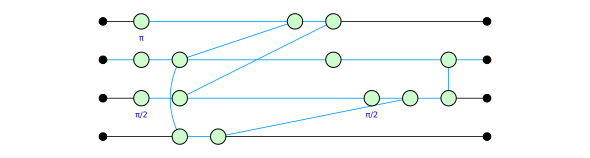

In [17]:
zx.draw_matplotlib(g1)

### 1. Spider_simp

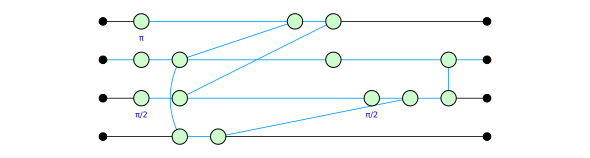

In [18]:
zx.simplify.spider_simp(g1)
zx.draw_matplotlib(g1)

### 2. Convert to Graph like form

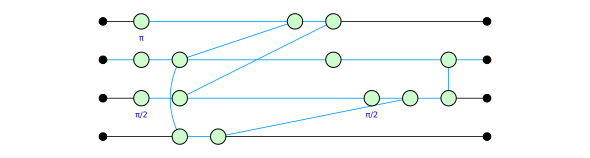

In [19]:
zx.simplify.to_gh(g1)
zx.draw_matplotlib(g1)

In [20]:
import copy

In [21]:
# Copy の挙動
g2 = g1.copy()
print(g1.vertices())
print(g2.vertices())
print(g2.vertices().__class__)
g3 = g2.copy()

g4 = copy.deepcopy(g1)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
<class 'dict_keys'>


In [22]:
keys1 = g2.vertices()
keys2 = g3.vertices()

if keys1 == keys2:print("Ok") 
else: print("False")

keys1 = g1.vertices()
keys2 = g4.vertices()

if keys1 == keys2:print("Ok") 
else: print("False")

Ok
Ok


### 3. Rewrite with id, fuse, lcomp, pivot
First, try to understand the methods to find matches for each rewrite

1. id

In [23]:
print("1 candidate info", zx.rules.match_ids(g1)) # Return 1 candidate information
print("All candidates info", zx.rules.match_ids_parallel(g1)) # Return all candidates

# Candidates info [Identity Vertex, neighbor Vertex (n1), n2, Edge-type]

1 candidate info [(4, 1, 5, 1)]
All candidates info [(4, 1, 5, 1), (23, 24, 5, 1)]


In [24]:
g = g1.copy()
Id_Matchs = zx.rules.match_ids_parallel(g)
print(Id_Matchs)
print(list(Id_Matchs[1]).__class__)
print([Id_Matchs[1]])

[(4, 1, 5, 1), (15, 5, 16, 1)]
<class 'list'>
[(15, 5, 16, 1)]


In [25]:
def apply_simp(
    g,
    rewrite_function,
    match,
):
    g1 = deepcopy(g)
    etab, rem_verts, rem_edges, check_isolated_vertices = \
    rewrite_function(g,match)
    g1.add_edge_table(etab)
    g1.remove_edges(rem_edges)
    g1.remove_vertices(rem_verts)
    if check_isolated_vertices: g1.remove_isolated_vertices()
    return g1

In [26]:
etab, rem_verts, rem_edges, check_isolated_vertices = zx.rules.remove_ids(g, [(1, 2, 5, 1)])

適当なのにすると、エラーでずに、フツーにぐちゃぐちゃに実行するやん

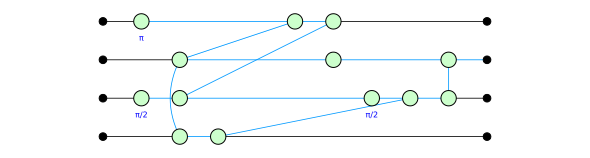

In [27]:
gk = apply_simp(g, zx.rules.remove_ids, [(4, 1, 5, 1)])
zx.draw_matplotlib(gk)

2. Fuse

In [28]:
print("1 candidate info", zx.rules.match_spider(g1)) # Return 1 candidate information
print("All candidates info", zx.rules.match_spider_parallel(g1)) # Return all candidates

# Candidates info [Vertex can be fused 1, V2]

1 candidate info []
All candidates info []


In [29]:
g = g1.copy()
Fuse_matches = zx.rules.match_spider_parallel(g)
print(Fuse_matches)

[]


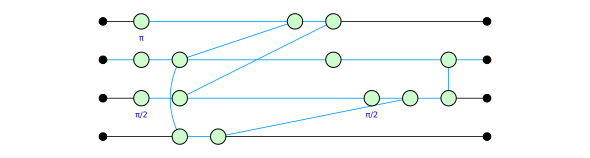

In [30]:
etab, rem_verts, rem_edges, check_isolated_vertices = zx.rules.spider(g, Fuse_matches)
g.add_edge_table(etab)
g.remove_edges(rem_edges)
g.remove_vertices(rem_verts)
if check_isolated_vertices: g.remove_isolated_vertices()
zx.draw_matplotlib(g)

3. pivot

In [31]:
print("1 candidate info", zx.rules.match_pivot(g1)) # Return 1 candidate information
print("All candidates info", zx.rules.match_pivot_parallel(g1)) # Return all candidates

# Candidates info ??

1 candidate info [(21, 25, [], [28])]
All candidates info [(21, 25, [], [28]), (5, 16, [], [])]


### copy()使ったら、ラベル変わってるんだが
もう、class 定義のcopy ではなく、deepcopy 使いましょう

In [32]:
g = g1.copy()
Pivot_matches = zx.rules.match_pivot_parallel(g)
print(Pivot_matches)

[(4, 5, [1], []), (10, 14, [21], []), (9, 12, [], [18])]


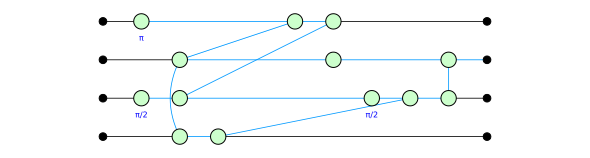

In [33]:
etab, rem_verts, rem_edges, check_isolated_vertices = zx.rules.pivot(g, [Pivot_matches[0]])
g.add_edge_table(etab)
g.remove_edges(rem_edges)
g.remove_vertices(rem_verts)
if check_isolated_vertices: g.remove_isolated_vertices()
zx.draw_matplotlib(g)

4. lcomp

In [34]:
print("1 candidate info", zx.rules.match_lcomp(g1)) # Return 1 candidate information
print("All candidates info", zx.rules.match_lcomp_parallel(g1)) # Return all candidates

# Candidates info [Target Vertex, ??]

1 candidate info [(20, [21, 9])]
All candidates info [(20, [21, 9])]


In [35]:
g = g1.copy()
Lcomp_matches = zx.rules.match_lcomp_parallel(g)
print(Lcomp_matches)

[(13, [9, 14])]


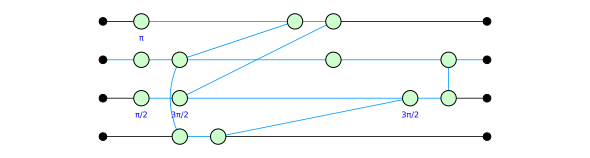

In [36]:
etab, rem_verts, rem_edges, check_isolated_vertices = zx.rules.lcomp(g, [Lcomp_matches[0]])
g.add_edge_table(etab)
g.remove_edges(rem_edges)
g.remove_vertices(rem_verts)
if check_isolated_vertices: g.remove_isolated_vertices()
zx.draw_matplotlib(g)